## Chest pathology detection


### Initialize TensorFlow 2.0 and Mount the google drive to consume data

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.0'

In [2]:
# Initialize the random number generator
import random
from tensorflow.keras import utils
random.seed(0)

# Ignore the warnings
#import warnings
#warnings.filterwarnings("ignore")

In [3]:
# In order to use tqdm progress bar library....
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [4]:
# run this cell to to mount the google drive if you are using google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
import matplotlib.pyplot as plt
import numpy as np

Store the train/test and all csv files in google drive instead of storing in the VM for faster access. Also we will not lose train/test directories when the VM is reallocated..

In [6]:
train_dir_path = '/content/drive/My Drive/Dec2020_processed_data/data/train/'
test_dir_path = '/content/drive/My Drive/Dec2020_processed_data/data/test/'

metadata_dir_path = '/content/drive/My Drive/Dec2020_processed_data/data/metadata/'
vm_train_dir = "/content/train/"
vm_trainx_dir = "/content/trainX/"
vm_valx_dir = "/content/valX"
vm_test_dir = "/content/test/" # Not used for now.

num_classes = 3

In [7]:
!ls '/content/drive/My Drive/Dec2020_processed_data/data/train'

xray-images-train.zip


In [8]:
!mkdir "/content/train"
!mkdir "/content/trainX"
!mkdir "/content/valX"
!mkdir "/content/test"

### Unzip the Dataset Files (One time execution until the lifetime of the colab container)

In [9]:
from zipfile import ZipFile

# There are 3 train files
with ZipFile(train_dir_path+'xray-images-train.zip', 'r') as z:
  z.extractall(vm_train_dir)

In [10]:
!ls '/content/train' | wc -l

13958


Repeat the same step for test.zip

In [11]:
# Test file
with ZipFile(test_dir_path+'xray-images-test.zip', 'r') as z:
  z.extractall(vm_test_dir)

In [12]:
!ls '/content/test' | wc -l

1579


### Read the Train and Test csv file using pandas

In [13]:
import pandas as pd

lungxray_train_df = pd.read_csv(metadata_dir_path + 'train_split.txt',delimiter=' ', names=['patient_id', 'xray_img_name', 'target_class', 'img_source'])
lungxray_train_df.shape

(13958, 4)

In [14]:
lungxray_train_df.head()

,patient_id,xray_img_name,target_class,img_source
0,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia,cohen
1,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia,cohen
2,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia,cohen
3,7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia,cohen
4,7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia,cohen


In [15]:
lungxray_train_df.nunique()['xray_img_name']

13958

30 images are either duplicate or augumented with same name. Examine these images by plotting (Need to do more EDA)

In [16]:
lungxray_test_df = pd.read_csv(metadata_dir_path + 'test_split.txt',delimiter=' ', names=['patient_id', 'xray_img_name', 'target_class', 'img_source'])
lungxray_test_df.shape

(1579, 4)

In [17]:
lungxray_test_df.head()

,patient_id,xray_img_name,target_class,img_source
0,8,SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9...,pneumonia,cohen
1,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia,cohen
2,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia,cohen
3,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia,cohen
4,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia,cohen


### Split the train data in the labels.csv into train and validation dataframes. (Using Stratify)

This is prep work for to use tensor flow 2.0 API's. Tensor flow uses this dataframe to train the model in batches

In [ ]:
# Train / Validation split on the dog_labels_df
# Split train data into training and validation.
from sklearn.model_selection import train_test_split

trn_df, val_df = train_test_split(lungxray_train_df, test_size=0.2, random_state=50, 
                                  stratify=lungxray_train_df['target_class'])
#trn_df['xray_img_name'] = trn_df['xray_img_name'] + ".jpg"
#val_df['xray_img_name'] = val_df['xray_img_name'] + ".jpg"

print(trn_df.shape)
print(val_df.shape)

(11166, 4)
(2792, 4)


In [ ]:
trn_df.shape
val_df.shape

(2792, 4)

### Block to split train into trainX and valX images to facilitate flow_from_dataframe calls

This will be done based on trn_df and val_df dataframes

In [ ]:
import os

def create_dir_in_colab_runtime(path):
  # define the name of the directory to be created
  # define the access rights
  access_rights = 0o755

  try:
      os.mkdir(path, access_rights)
  except OSError:
      print ("Creation of the directory %s failed" % path)
  else:
      print ("Successfully created the directory %s" % path)
  return

In [ ]:
# importing shutil module  
import shutil
import os
import sys

# Source path  
src_dir = '/content/train/'  
# Destination paths  
new_train_dir = '/content/trainX/'
new_val_dir = '/content/valX/'

#create_dir_in_colab_runtime(new_train_dir)
#create_dir_in_colab_runtime(new_val_dir)

# Before copying check the number of files in TRAIN directory
src_path, src_dirs, src_files = next(os.walk(src_dir))
src_file_count = len(src_files)
print("train file counts :", src_file_count)

# Move the data from train into trainX and valX 
# Keep the original train as is to maintain the data integrity for future experiments

with tqdm(total=len(trn_df['xray_img_name'].values), file=sys.stdout) as pbar:
  for s in trn_df['xray_img_name'].values:
    pbar.update(1)
    new_trn_path = shutil.copy(src_dir + s, new_train_dir)
pbar.close()

with tqdm(total=len(val_df['xray_img_name'].values), file=sys.stdout) as pbar:
  for t in val_df['xray_img_name'].values:
    pbar.update(1)
    new_val_path = shutil.copy(src_dir + t, new_val_dir)
pbar.close()

trn_path, trn_dirs, trn_files = next(os.walk(new_train_dir))
trn_file_count = len(trn_files)

val_path, val_dirs, val_files = next(os.walk(new_val_dir))
val_file_count = len(val_files)

print("TrainX file count :", trn_file_count)
print("valX file count :", val_file_count)

train file counts : 13958


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



TrainX file count : 11166
valX file count : 2792


In [ ]:
!ls '/content/valX' | wc -l

2792


In [ ]:
!ls -l '/content/test/0a13f9596e03a9f87c96aaff6e057048.jpg'

ls: cannot access '/content/test/0a13f9596e03a9f87c96aaff6e057048.jpg': No such file or directory


### Print the count of each category of chest pathology given in the dataset



In [18]:
lungxray_train_df.groupby('target_class').count()

,patient_id,xray_img_name,img_source
target_class,,,
COVID-19,517,517,517
normal,7966,7966,7966
pneumonia,5475,5475,5475


In [35]:
tmp = lungxray_train_df[lungxray_train_df['target_class'] == "pneumonia"]
tmp['patient_id'].nunique()

5451

In [18]:
lungxray_train_df.groupby('img_source').count()

,patient_id,xray_img_name,target_class
img_source,,,
actmed,25,25,25
cohen,491,491,491
fig1,24,24,24
rsna,13389,13389,13389
sirm,29,29,29


In [25]:
lungxray_train_df.groupby('patient_id').count()

,xray_img_name,target_class,img_source
patient_id,,,
000924cf-0f8d-42bd-9158-1af53881a557,1,1,1
000db696-cf54-4385-b10b-6b16fbb3f985,1,1,1
000fe35a-2649-43d4-b027-e67796d412e0,1,1,1
001031d9-f904-4a23-b3e5-2c088acd19c6,1,1,1
0010f549-b242-4e94-87a8-57d79de215fc,1,1,1
...,...,...,...
ffe16061-b19f-4333-8a03-b41aab42b47d,1,1,1
fff0b503-72a5-446a-843d-f3d152e39053,1,1,1
fff50447-821b-4b72-ae91-22b0679d6d3e,1,1,1


### Common functions required for all models
* Plot accuracy loss
* Round_up

In [19]:
import math

def plot_train_val_accuracy(history,title):
  plt.title(title)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
  plt.show()


def plot_train_accuracy(history,title):
  plt.title(title)
  plt.plot(history.history['accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_accuracy'], loc='best')
  plt.show()


def plot_train_val_loss(history,title):
  plt.title(title)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'validation_loss'], loc='best')
  plt.show()

def plot_train_loss(history,title):
  plt.title(title)
  plt.plot(history.history['loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss'], loc='best')
  plt.show()

def round_up(n, decimals=0): 
  multiplier = 10 ** decimals 
  return math.ceil(n * multiplier) / multiplier

### Transfer Learning - Using Darknet-53.
* Darknet-53 was extracted from Yolo-v3 using pjreddie and qqwweee repos in github. Yolov3 is written in C using CUDA libraries.
* Darknet-53 extraction is kept as a separate notebook. This notebook only deals with consumption of Darknet-53 for classification

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Flatten, BatchNormalization, Dropout)
from tensorflow.keras.optimizers import (SGD, Adam)

# Load model
model_dark53 = load_model(filepath="/content/drive/My Drive/yolo-weights/darknet53_416px_imgnet_final.tf", compile=True)

# Check the architecture...
#print(model_dark53.outputs)


fc_dark53_model = Sequential([model_dark53,
                          Flatten(),
                          Dense(1024, activation='relu'),
                          BatchNormalization(name="a"),
                          Dropout(0.6),
                          Dense(512, activation='relu'),
                          BatchNormalization(name="b"),
                          Dropout(0.6),
                          Dense(3, activation='softmax')])

'''
fc_dark53_model = Sequential([model_dark53,
                          Flatten(),
                          Dense(1024, activation='relu'),
                          Dense(3, activation='softmax')]
                         )
'''
'''
fc_dark53_model = Sequential([model_dark53,
                          Flatten(),
                          Dense(3, activation='softmax')]
                         )
'''
# Step 1-Compile using the same specs as Darknet-53.cfg
#optimizer = SGD(lr=0.001, decay=0.0005, momentum=0.9)

# Step 2-Compile using a learning rate less than specified in darknet53.cfg
optimizer = Adam(learning_rate=0.00001)
fc_dark53_model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])

fc_dark53_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 1024)              40620640  
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
a (BatchNormalization)       (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
b (BatchNormalization)       (None, 512)               2

In [21]:
input_resolution = 448
img_height = input_resolution
img_width = input_resolution
batch_size = 16
epochs = 20

#### Use this block to do TRAIN and VALIDATE

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_name = '/content/drive/My Drive/Colab Notebooks/chest_pathology/Dec2020/chkpts/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
#checkpoint_name = 'Weights-009--0.01534.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

#train_datagen = ImageDataGenerator(rescale=1./255, 
#                                   preprocessing_function = preprocess_input)

#train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
#                                   shear_range=0.2,
#                                   zoom_range=0.2)

#train_datagen = ImageDataGenerator()

'''
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
'''                                  

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')

# Train data - prepare data augmentation configuration 
#train_datagen = ImageDataGenerator()

# Train data - Get it ready with augumentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=trn_df, 
    directory=vm_train_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle=True)

# Test data - Get it ready - No augumentation
#valid_datagen = ImageDataGenerator(rescale=1./255, 
#                                   preprocessing_function = preprocess_input)

valid_datagen = ImageDataGenerator()

#valid_datagen = ImageDataGenerator()

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_df, 
    directory=vm_valx_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle = True)

# Start training the model...
STEP_SIZE_TRAIN=round_up(train_generator.n/train_generator.batch_size)
STEP_SIZE_VALID=round_up(valid_generator.n/valid_generator.batch_size)

print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

history = fc_dark53_model.fit_generator(
    generator=train_generator,
    callbacks = callbacks_list,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=epochs)

plot_train_val_accuracy(history, "Darknet-53  - Accuracy")
plot_train_val_loss(history, "Darknet-53 - Loss")

Found 11166 validated image filenames belonging to 3 classes.
Found 2792 validated image filenames belonging to 3 classes.
349.0 88.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
349/349 [==============================] - 536s 1s/step - loss: 0.8851 - accuracy: 0.8225 - val_loss: 0.6513 - val_accuracy: 0.9259

Epoch 00001: val_loss improved from inf to 0.65130, saving model to /content/drive/My Drive/chest_pathology/Dec2020/chkpts/Weights-001--0.65130.hdf5
Epoch 2/20
214/349 [=================>............] - ETA: 2:57 - loss: 0.5994 - accuracy: 0.9452

KeyboardInterrupt: ignored

#### Use this block for TRAIN & TEST

Use this code to resume training from a checkpoint 'n'

In [24]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# load the model
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/chest_pathology/Dec2020/chkpts/Weights-013--0.64821.hdf5'
new_model = load_model(checkpoint_path)

# This should not be checkpoint_path, rather it should be with pattern...so that the model epoch number / loss is reflected in the filename..
checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')

'''
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
'''

# Train data - Get it ready with augumentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=lungxray_train_df, 
    directory=vm_train_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle=True)

# Start training the model...
STEP_SIZE_TRAIN=round_up(train_generator.n/train_generator.batch_size)

print(STEP_SIZE_TRAIN)

history = new_model.fit_generator(
    generator=train_generator,
    callbacks = callbacks_list,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs)

plot_train_accuracy(history, "Darknet-53 - Accuracy")
plot_train_loss(history, "Darknet-53 - Loss")

Use this code to start from checkpoint 0

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_name = '/content/drive/My Drive/Colab Notebooks/chest_pathology/Dec2020/chkpts/Weights-{epoch:03d}--{loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

Found 13958 validated image filenames belonging to 3 classes.
873.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
873/873 [==============================] - 948s 1s/step - loss: 1.5763 - accuracy: 0.6430

Epoch 00001: loss improved from inf to 1.32159, saving model to /content/drive/My Drive/Colab Notebooks/chest_pathology/Dec2020/chkpts/Weights-001--1.32159.hdf5
Epoch 2/20
873/873 [==============================] - 928s 1s/step - loss: 1.0422 - accuracy: 0.8276

Epoch 00002: loss improved from 1.32159 to 0.99960, saving model to /content/drive/My Drive/Colab Notebooks/chest_pathology/Dec2020/chkpts/Weights-002--0.99960.hdf5
Epoch 3/20
873/873 [==============================] - 920s 1s/step - loss: 0.9043 - accuracy: 0.8680

Epoch 00003: loss improved from 0.99960 to 0.89280, saving model to /content/drive/My Drive/Colab Notebooks/chest_pathology/Dec2020/chkpts/Weights-003--0.89280.hdf5
Epoch 4/20
873/873 [==============================] - 919s 1s/step - loss: 0.8746 - accuracy: 0.8817

Epoch 00004: loss improved from 0.89280 to 0.85390, saving model to /content/drive/My Drive/Colab Not

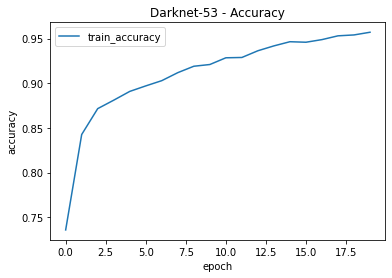

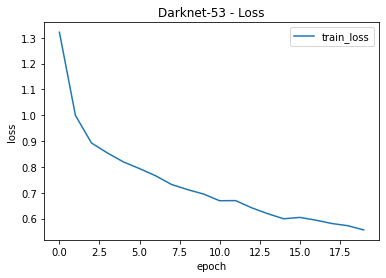

In [23]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')

'''
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
'''

# Train data - Get it ready with augumentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=lungxray_train_df, 
    directory=vm_train_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle=True)

# Start training the model...
STEP_SIZE_TRAIN=round_up(train_generator.n/train_generator.batch_size)

print(STEP_SIZE_TRAIN)

history = fc_dark53_model.fit_generator(
    generator=train_generator,
    callbacks = callbacks_list,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs)

plot_train_accuracy(history, "Darknet-53 - Accuracy")
plot_train_loss(history, "Darknet-53 - Loss")

In [24]:
}fc_dark53_model.save('/content/drive/My Drive/Colab Notebooks/chest_pathology/Dec2020/saved_model/darknet_testid_14')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/chest_pathology/Dec2020/saved_model/darknet_testid_14/assets


In [ ]:
ls -l '/content/drive/My Drive/Colab Notebooks/chest_pathology/Dec2020/chkpts/Weights-015--0.37705.hdf5'

total 1466275
drwx------ 2 root root      4096 Jan  8 17:53 testid_21/
-rw------- 1 root root 500486824 Jan  8 18:35 Weights-001--0.72825.hdf5
-rw------- 1 root root 500486824 Jan  8 18:51 Weights-002--0.61608.hdf5
-rw------- 1 root root 500486824 Jan  8 19:07 Weights-003--0.57230.hdf5


Print the Test loss, accuracy and confusion matrix

In [25]:
# Print the loss and accuracy
from sklearn import metrics
# Import label encoder 
from sklearn import preprocessing 

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=lungxray_test_df, 
    directory=vm_test_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle = False)

print("Test Gen classes :",test_generator.class_indices)

STEP_SIZE_TEST=round_up(test_generator.n/test_generator.batch_size)

loss, accuracy = fc_dark53_model.evaluate_generator(test_generator, 
                                              steps = STEP_SIZE_TEST,
                                              verbose = 1)

print('Accuracy: %.3f'  % accuracy)
print('Loss: %.3f' % loss)

y_predict = fc_dark53_model.predict_generator(test_generator,
                                        steps = STEP_SIZE_TEST,
                                        verbose = 1)

y_predict = np.argmax(y_predict, axis=1)

# First Label encode strings into integers. 
label_encoder = preprocessing.LabelEncoder() 
y_actual = label_encoder.fit_transform(lungxray_test_df['target_class'])

print("LE classes :",label_encoder.classes_)

cm = metrics.confusion_matrix(y_actual,y_predict)
print(cm)
print(metrics.classification_report(y_actual, y_predict))

Found 1579 validated image filenames belonging to 3 classes.
Test Gen classes : {'COVID-19': 0, 'normal': 1, 'pneumonia': 2}


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


99/99 [==============================] - 42s 405ms/step - loss: 0.5858 - accuracy: 0.9405
Accuracy: 0.940
Loss: 0.586


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


99/99 [==============================] - 35s 348ms/step
LE classes : ['COVID-19' 'normal' 'pneumonia']
[[ 67   8  25]
 [  0 851  34]
 [  0  27 567]]
              precision    recall  f1-score   support

           0       1.00      0.67      0.80       100
           1       0.96      0.96      0.96       885
           2       0.91      0.95      0.93       594

    accuracy                           0.94      1579
   macro avg       0.96      0.86      0.90      1579
weighted avg       0.94      0.94      0.94      1579

